In [123]:
import pandas as pd
import pickle
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import Ridge
import scipy.stats as sts
from scipy.special import expit as sigmoid

## 1. Прочитайте и проанализируйте данные


In [2]:
# with open('chgk/players.pkl', 'rb') as f:
#     names = pickle.load(f)
with open('chgk/results.pkl', 'rb') as f:
    results = pickle.load(f)
with open('chgk/tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)

In [3]:
tournaments_pd = pd.DataFrame(tournaments.values())
tournaments_pd['dateStart'] =  pd.to_datetime(tournaments_pd.dateStart.apply(lambda x: x.split('T')[0]))
tournaments_pd.sort_values('dateStart', inplace=True)

In [4]:
def make_one_hot_type(id_):
    zer = np.zeros((9))
    zer[id_] = 1
    return zer

train_tour = tournaments_pd[(tournaments_pd.dateStart < '2020') & (tournaments_pd.dateStart >= '2019')]
test_tour = tournaments_pd[(tournaments_pd.dateStart >= '2020')]

train_tour.type = train_tour.type.apply(lambda x: make_one_hot_type(x['id']))
test_tour.type = test_tour.type.apply(lambda x: make_one_hot_type(x['id']))

train_tour['total_questions'] = train_tour.questionQty.apply(lambda x: sum(list(x.values())))
test_tour['total_questions'] = test_tour.questionQty.apply(lambda x: sum(list(x.values())))

# возьмем самые часто-встречающися турниры
test_tour = test_tour[test_tour.total_questions == 36]
train_tour = train_tour[train_tour.total_questions == 36]

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [30]:
# train_tour.total_questions.value_counts().head()
# оставим игры где было только 36 вопросов (чтобы итоговые матрицы влезли в память)

36    392
45     64
60     35
39     28
90     28
Name: total_questions, dtype: int64

In [5]:
del tournaments_pd
del tournaments

In [6]:
# вытащим результаты
known_teams_results = []
for tour_id, team_reslut in results.items():
    for team in team_reslut:
        if ('mask' in team.keys()) and ('teamMembers' in team.keys()) and (team['mask'] is not None) and len(team['teamMembers']) > 0:
#             не знаю что значат эти символы поэтому лучше их убрать 
            if not ('X' in team['mask'] or '?'  in team['mask']):
                team['tour_id'] = tour_id
                known_teams_results.append(team)

In [7]:
teams = pd.DataFrame(known_teams_results)
teams = teams[teams.tour_id.isin(train_tour.id)]

In [9]:
players_set = set()
for team in teams.teamMembers.values:
    for player in team:
        players_set.add(player['player']['id'])

In [10]:
print('Всего уникальных игроков в трейне', len(players_set))

Всего уникальных игроков в трейне 49504


In [47]:
# делаем словарики для one-hot векторов
id_vec_to_id = {i:id_ for i, id_ in enumerate(players_set)}
id_to_id_vec = {id_:i for i, id_ in enumerate(players_set)}

Бейзлайн - линейная регрессия, где X - это вектор команды (длинной 49504) , а target это вектор суммы one-hot векторов вопросов этого турнира

In [12]:
# с большими матрицами тут возникают большие проблемы с лин-регом из коробки
y = sparse.lil_matrix((teams.shape[0], train_tour.shape[0]*36),  dtype=float)

start_tour = 4772
counter = 0
for i in range(len(teams)):
    current_ans = list(teams['mask'].values[i])
    if teams['tour_id'].values[i] != start_tour:
        counter += 36
        start_tour = teams['tour_id'].values[i]
        
    for result in range(len(current_ans)):
        y[i, result+counter] = int(current_ans[result])

In [49]:
X = sparse.lil_matrix((teams.shape[0], len(players_set)),  dtype=int)
for i in range(len(teams)):
    for player in teams.teamMembers.values[i]:
        X[i, id_to_id_vec[player['player']['id']]] = 1

In [50]:
assert X.shape[0] == y.shape[0]

In [18]:
y = y.todense()

AttributeError: 'matrix' object has no attribute 'todense'

In [51]:
# одна итерация шла очень долго, поэтому из за нехватки времени получается недообученная штука
lr = Ridge(max_iter=1)

In [52]:
lr.fit(X,y)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1, normalize=False,
      random_state=None, solver='auto', tol=0.001)

(array([9.0000e+00, 1.0500e+02, 2.4570e+03, 2.7140e+04, 1.5399e+04,
        3.4850e+03, 7.7600e+02, 1.1600e+02, 1.3000e+01, 4.0000e+00]),
 array([-5.26103072, -3.93173671, -2.60244271, -1.2731487 ,  0.0561453 ,
         1.38543931,  2.71473331,  4.04402732,  5.37332132,  6.70261532,
         8.03190933]),
 <a list of 10 Patch objects>)

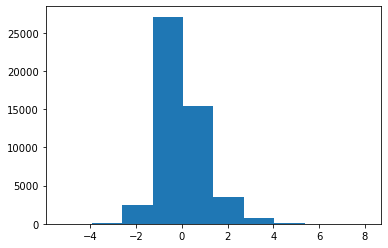

In [53]:
# распредление "сил" игроков
plt.hist(lr.coef_.sum(axis=0))

In [54]:
# силы игроков и сложность вопросов
pl_rate = lr.coef_.sum(axis=0)
question_rate = lr.coef_.sum(axis=1)

In [56]:
array_pl_rate = [(id_vec_to_id[i], score) for i, score in enumerate(pl_rate)]
array_pl_rate = sorted(array_pl_rate, key=lambda x: x[1], reverse=True)

In [77]:
def get_player_position(id_):
    url = f'https://rating.chgk.info/api/players/{id_}/rating/last'
    position = int(requests.get(url).json()['rating_position'])
    return position

In [65]:
# посмотрим насколько удачно получилось составить рейтинг
df_rating = pd.DataFrame(array_pl_rate, columns=['id', 'score'])[:50]
df_rating['actual_position'] = df_rating['id'].apply(get_player_position)

In [74]:
df_rating[df_rating.actual_position < 50]

,id,score,actual_position
1,18332,7.312199,7
3,5990,7.194615,20
33,28751,4.991755,2


In [75]:
# Всего три человека попали в актуальный топ 50
# но это можно объяснить андерфитом и не отсечением людей сыгравших больше 1000 вопросов

## 3. Оценка качества
Будем считать суммарный вес команды (по коэффициентам, предварительно выкинув неизвестных участников), позиции в итоговом зачете будем считать позициями в отсортированом массиве весов

In [103]:
test_teams = pd.DataFrame(known_teams_results)
test_teams = test_teams[test_teams.tour_id.isin(test_tour.id)]

In [95]:
cumml_rating = []
for team in test_teams.teamMembers.values:
    team_rate = 0
    for member in team:
        if id_to_id_vec.get(member['player']['id']):
            team_rate += pl_rate[id_to_id_vec[member['player']['id']]]
    cumml_rating.append(team_rate)

In [104]:
test_teams['sum_rate'] = cumml_rating

In [105]:
test_teams.sort_values(['tour_id','sum_rate'], inplace=True)

In [115]:
pred_pos = []
for tour_id in test_teams['tour_id'].unique():
    tour_teams_len = test_teams[test_teams.tour_id == tour_id].shape[0]
    pred_pos.append(list(range(tour_teams_len, 0, -1)))  
pred_pos = sum(pred_pos, [])
test_teams['pred_pos'] = pred_pos

А корреляции получились очень даже ничего!

In [127]:
print('Корреляция Спирмена:', sts.spearmanr(test_teams['position'].values, test_teams['pred_pos'].values).correlation)

Корреляция Спирмена: 0.8410886802038086


In [128]:
print('Корреляция Кендалла:', sts.kendalltau(test_teams['position'].values, test_teams['pred_pos'].values).correlation)

Корреляция Кендалла: 0.6648913092835894


## 4. EM-алгоритм


Попробуем вернуться к задаче классификации и скорректировать силы наших игроков. Попытаемся найти вероятность правильного ответа ИГРОКА при условии правильного ответа КОМАНДЫ.

p(игрок=1 | команда=1) = p(игрок=1) * p(команды=1|игрок=1) / p (команды)

Предположим что наш игрок капитан, что команда всегда отвечает правильно, если игрок ответил правильно


П = p(игрок=1 | команда=1) = p(игрок=1) * 1 / p (команды)

Е-шаг - вычисление вероятности П

М-шаг - обучение логистической регрессии и обновление вероятностей  p(игрок=1) / p (команды)

In [144]:
X_lil_ = sparse.lil_matrix((X.shape[0]*36, len(players_set)),  dtype=int)

In [149]:
counter = 0
for i in range(len(teams)):
    for j in range(36):
        for player in teams.teamMembers.values[i]:
            X_lil_[36*i + j, id_to_id_vec[player['player']['id']]] = 1

In [165]:
y = np.zeros((teams['mask'].shape[0] * 36))
for j, i in enumerate(teams['mask'].values):
    if j != 27723:
        y[j*36 : j*36 + 36] = list(map(int, i))        

In [179]:
class LogReg:
    def __init__(self, w):
        self.w = np.hstack((np.ones((1)), w))
        
    def fit(self, X, y, max_iters=10):
        X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X], format='csr')     
        losses = []
        prev_mean_loss = np.inf
        
        for i in range(max_iters):
            batch_idxs = np.random.choice(X.shape[0], 1024)
            X_batch = X[batch_idxs, :]
            y_batch = y[batch_idxs]
            preds = sigmoid(X_batch.dot(self.w))
            losses.append(self.logloss(y_batch, preds))
            if (i + 1) % 1024 == 0:
                new_mean_loss = np.mean(losses)
                if (prev_mean_loss - new_mean_loss) < 0.000001:
                    break                    
                losses = []
                prev_mean_loss = new_mean_loss

            grad = -X_batch.T.dot(y_batch - preds) / len(y_batch)
            self.w -= 5 * grad 
    
    def predict_proba(self, X):
        X = sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
        preds = sigmoid(X.dot(self.w))
        return np.hstack(((1 - preds).reshape(-1, 1), preds.reshape(-1, 1)))
    
    def logloss(y, p):
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [216]:
estimator = LogReg(pl_rate)
estimator.fit(X_lil_, y)

In [217]:
for _ in range(3):
    
    preds = estimator.predict_proba(X_lil_)
    
    for i in range(0, preds.shape[0], 36):
        preds[i:i+36] /= preds[i:i+36].sum(axis=0)/36
    z = (preds[:, 0]).clip(0, 1)
    z[y == 0] = 0
    estimator.fit(X_lil_, z)
    
    
    test_teams = pd.DataFrame(known_teams_results)
    test_teams = test_teams[test_teams.tour_id.isin(test_tour.id)]
    
    cumml_rating = []
    for team in test_teams.teamMembers.values:
        team_rate = 0
        for member in team:
            if id_to_id_vec.get(member['player']['id']):
                team_rate += estimator.w[id_to_id_vec[member['player']['id']]]
        cumml_rating.append(team_rate)
    test_teams['sum_rate'] = cumml_rating
    test_teams.sort_values(['tour_id','sum_rate'], inplace=True)
    pred_pos = []
    for tour_id in test_teams['tour_id'].unique():
        tour_teams_len = test_teams[test_teams.tour_id == tour_id].shape[0]
        pred_pos.append(list(range(tour_teams_len, 0, -1)))  
    pred_pos = sum(pred_pos, [])
    test_teams['pred_pos'] = pred_pos
    print('Корреляция Спирмена:', sts.spearmanr(test_teams['position'].values, test_teams['pred_pos'].values).correlation)
    print('Корреляция Кендалла:', sts.kendalltau(test_teams['position'].values, test_teams['pred_pos'].values).correlation)

Корреляция Спирмена: 0.8743700086530591
Корреляция Кендалла: 0.6992005506038511
Корреляция Спирмена: 0.8734222438368548
Корреляция Кендалла: 0.6983535757017642
Корреляция Спирмена: 0.8725383703432718
Корреляция Кендалла: 0.69752700236108344


Немного выросла, но начала убывать
Возможно кривая реализация

## 5. Рейтинг турниров по сложности вопросов


In [222]:
array_question_rate = [(i, score) for i, score in enumerate(question_rate)]
array_question_rate = sorted(array_question_rate, key=lambda x: x[1], reverse=True)

In [253]:
q_f = pd.DataFrame(list(map(lambda x: x[0]//36, array_question_rate))).drop_duplicates()

In [254]:
new_f = train_tour.reset_index(drop=True).reset_index()

In [260]:
q_f

,0
0,286
8,290
23,190
24,291
27,214
...,...
8965,312
9078,255
9798,251
13836,178


### Самые простые турниры

In [259]:
new_f[new_f.index == 286]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
286,286,5994,Открытая лига КФУ,2019-10-12,2020-02-22T19:00:00+03:00,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",/seasons/53,"[{'id': 46976, 'name': 'Мансур', 'patronymic':...",None,"{'1': 12, '2': 12, '3': 12}",36


In [261]:
new_f[new_f.index == 290]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
290,290,5751,Балтийский Берег. 1 игра,2019-10-17,2019-10-23T23:55:00+03:00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",/seasons/53,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-10-22T23:59:59...,"{'1': 12, '2': 12, '3': 12}",36


In [262]:
new_f[new_f.index == 190]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
190,190,5726,Первый турнир имени Джоуи Триббиани,2019-06-28,2019-09-26T18:00:00+03:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",/seasons/53,"[{'id': 121355, 'name': 'Виталий', 'patronymic...",{'dateRequestsAllowedTo': '2019-09-25T23:59:59...,"{'1': 12, '2': 12, '3': 12}",36


In [263]:
new_f[new_f.index == 291]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
291,291,5965,ОЧВР. 1 тур,2019-10-18,2019-10-23T19:00:00+03:00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",/seasons/53,"[{'id': 26469, 'name': 'Алексей', 'patronymic'...",{'dateRequestsAllowedTo': '2019-10-23T23:59:59...,"{'1': 12, '2': 12, '3': 12}",36


### Самые сложные турниры

In [264]:
new_f[new_f.index == 39]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
39,39,5390,Открытый Синхронный кубок Беларуси,2019-02-15,2019-02-19T00:00:00+03:00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",/seasons/52,"[{'id': 53126, 'name': 'Василий', 'patronymic'...",{'dateRequestsAllowedTo': '2019-02-19T23:59:59...,"{'1': 12, '2': 12, '3': 12}",36


In [265]:
new_f[new_f.index == 178]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
178,178,5684,Синхрон высшей лиги Москвы,2019-06-14,2019-06-18T19:00:00+03:00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",/seasons/52,"[{'id': 38458, 'name': 'Екатерина', 'patronymi...",{'dateRequestsAllowedTo': '2019-06-17T23:59:59...,"{'1': 12, '2': 12, '3': 12}",36


In [266]:
new_f[new_f.index == 251]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
251,251,5516,Синхрон Моносова,2019-09-13,2019-09-17T19:00:00+03:00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",/seasons/53,"[{'id': 21487, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-09-17T23:59:59...,"{'1': 12, '2': 12, '3': 12}",36


In [267]:
new_f[new_f.index == 312]

,index,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,total_questions
312,312,5718,Топ-1000,2019-11-07,2019-11-13T23:55:00+03:00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",/seasons/53,"[{'id': 21487, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-11-13T23:59:00...,"{'1': 12, '2': 12, '3': 12}",36


В целом все кажется достаточно адекатно